# I. Global overview of pyGPlates


If you want to install/use pyGPlates on your own laptop: [https://www.gplates.org/docs/pygplates/](https://www.gplates.org/docs/pygplates/)
Here is the repository for ipython notebooks demonstrating functionality of pygplates: [https://github.com/GPlates/pygplates-tutorials](https://github.com/GPlates/pygplates-tutorials)



- INPUT:    Reads GPlates resolved topology output, hardcoded below


- OUTPUT:   Several figures showing the statistics of mid ocean ridges


- METHOD: 
  - Takes GPlates resolved topology (CitcomS) ridge shapefile output and sums up the points along each feature, calculating the total ridge length, transform length.
  - Loop through GPlates resolved ridge topology output
  - Determine whether it is the type we want
  - March along the ridge and add up lengths of ridge/transform segments
  - Most of the work is done in the function 'ridgeloop', after that it is just plotting.


- WARNINGS: The initial strike takes the first and last points along the ridge, if this does not reflect the trend of the ridge, then the transforms and ridges will be mixed up.


- TODO:     Calculate proportion of MOR/Transform Calculate ridge obliquities Stats MOR Stats Subduction *Plate size Subduction



Copyright (C) 2019 The University of Sydney, Australia.  This file is part of GPlates.


This script has been designed using the documentation:
+ https://github.com/siwill22
+ https://github.com/GPlates/pygplates-tutorials
+ https://github.com/EarthByte/PlateTectonicTools

claire.mallard@sydney.edu.au

In [ ]:
import sys
sys.path.append('/Applications/pygplates_rev18_python27_MacOS64')
import pygplates
print "pygplates"
import math
print "math"
import os
print "os"
import numpy as np
import numpy
print "numpy"
import shapefile
print "Imported shapefile."
import pandas as pd
print "pandas"
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
print "imported matplotlib.pyplot"


%matplotlib inline
%load_ext autoreload
%autoreload 2

print pygplates.__version__

In [2]:
def readCSV(filename):
    '''
    Reads point data
    '''
    #lonMid, latMid, convRate, distance, \
    #orthAbs, orthOP, orthTrench,subObliquity,subPolarity,distEdge = \
    f=numpy.loadtxt(filename, delimiter=',')
    
    
    #return(lonMid, latMid, convRate, distance, \
    #orthAbs, orthOP, orthTrench,subObliquity,subPolarity,distEdge)
    return(f)

In [3]:
def latlon2pygplates(lat,lon):
    '''
    Convert lat lon to the pygplates formats
    '''
    pointLatLon = pygplates.LatLonPoint(lat,lon)
    pointXYZ = pygplates.convert_lat_lon_point_to_point_on_sphere(pointLatLon)
    pointXYZcart = numpy.array([pointXYZ.get_x(), pointXYZ.get_y(), pointXYZ.get_z()]) 
    
    return(pointXYZ,pointXYZcart)

In [4]:
def readTopologyPlatepolygonFile(filename,typeSLT):
    '''
    Reads shapefiles and returns the all the data fields
    '''
    shapeRead = shapefile.Reader(filename)

    recs    = shapeRead.records()
    shapes  = shapeRead.shapes()
    fields  = shapeRead.fields
    Nshp    = len(shapes)
    
    return(recs,shapes,fields,Nshp)

In [5]:
def getstrike(lon,lat,lon2,lat2):
    #Find the bearing of point 1 to point 2 (ALL IN RADIANS) from North
    #eqns from http://www.movable-type.co.uk/scripts/latlong.html
    radLat1 = numpy.radians(lat)
    radLat2 = numpy.radians(lat2)
    radLon1 = numpy.radians(lon)
    radLon2 = numpy.radians(lon2)
                            
    #θ = atan2( sin(Δλ).cos(φ2), cos(φ1).sin(φ2) − sin(φ1).cos(φ2).cos(Δλ) )
    bearingRad = numpy.arctan2( numpy.sin(radLon2-radLon1) * numpy.cos(radLat2),\
        numpy.cos(radLat1)*numpy.sin(radLat2) - \
        numpy.sin(radLat1)*numpy.cos(radLat2)*numpy.cos(radLon2-radLon1))

    return(bearingRad)

#  How can we use pyGplates?


## How to extract information from the GPlates reconstructions ?

The mantle-lithosphere interactions are still poorly know and can implies variabilities in the tectonic plates through times as you can see in the figure below (Andrew's publication reorganisation through time). We can use the GPlates reconstruction and the PyGplates tool to extract different informations of plate tectonic through time as:

+ Length of plate boundaries
+ Area/perimeter of plates
+ Area/perimeter of continents
+ Plate velocities

![...](Uyeda_study/xxx.png)

Here is a range of tool you can use to study the evolution of the surface tectonic:



## Import a list of functions and imports

In [6]:
import numpy
import pygplates
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Add directory containing the 'ptt' module (Plate Tectonic Tools) to the Python path. 
#If you need more informations, you can have a look on:  https://github.com/EarthByte/PlateTectonicTools 

import sys
sys.path.append('Resources/PlateTectonicTools-master')
import ptt
from ptt import ridge_spreading_rate
from ptt import separate_ridge_transform_segments



import sys
sys.path.append('Resources/GPlatesClassStruggle')
from reconstruction_classes import *

print pygplates.__version__

from reconstruction_classes import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.1.0.18


## Import the data of the reconstructions

In [7]:
# Import GPlates files available on [Uyeda_study/..] or https://www.earthbyte.org/gplates-2-1-software-and-data-sets/

transform_segment_deviation_in_radians = separate_ridge_transform_segments.DEFAULT_TRANSFORM_SEGMENT_DEVIATION_RADIANS


rotation_model = pygplates.RotationModel('Data/Matthews_etal_GPC_2016_410-0Ma_GK07.rot')
dynamic_polygons = ['Data/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz',
                    'Data/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz',
                    'Data/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz']





In [8]:
# Choose the time-step you want to study

reconstruction_time = 0.

# and the type of data you want to extract
resolved_topologies = []
resolved_topological_sections = []
pygplates.resolve_topologies(dynamic_polygons,
                             rotation_model,
                             resolved_topologies,
                             reconstruction_time,
                             resolved_topological_sections)



In [9]:
# Extract the ID of the major plates and their associated area and perimeter in km2 and km

print(" ID" , "," , "Area (km^2)",",", "Perimeter (km)")
for resolved_topology in resolved_topologies:
    plate_id = resolved_topology.get_feature().get_reconstruction_plate_id()
    plate_area = resolved_topology.get_resolved_geometry().get_area() * pygplates.Earth.mean_radius_in_kms**2
    plate_perimeter = resolved_topology.get_resolved_geometry().get_arc_length() * pygplates.Earth.mean_radius_in_kms
    print(plate_id , plate_area, plate_perimeter)
    # export .dat



 ID , Area (km^2) , Perimeter (km)
701 59402232.0372 41764.1770966
802 57829568.6668 38874.419748
503 5420370.55158 9974.97465463
511 10736027.1903 15461.0170109
224 3360031.57214 10415.6570443
909 2910341.51917 7996.55985964
301 63200417.5533 44132.2840941
501 10411415.1063 14040.4322661
659 498855.277942 3154.38202074
699 371698.134758 3721.63198155
911 16296762.359 20023.0192724
824 889753.593263 3729.89565054
669 405061.075222 3121.11609697
201 43379987.2598 32837.3822778
709 19000168.5358 21985.027949
821 393896.712818 3801.30620834
406 506366.228471 3504.59624914
645 420142.775369 2630.12817724
677 187923.97635 1875.80309598
646 105206.137014 1550.04965777
664 286486.354731 2553.72867248
607 538625.012508 4805.33083347
686 763227.841552 6037.62160503
801 38934127.5496 32752.3581582
328 70858.2251156 1794.02682996
340 73385.1482685 1544.73751538
337 131949.488864 1838.07325636
334 138205.54582 1911.2948933
566 337491.121199 2856.89758266
678 824445.48036 5330.67626017
674 77217.70

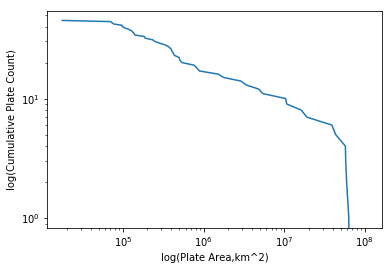

In [10]:
# Create a plot Count of plates vs. 

plate_areas = []

for topology in resolved_topologies:
    # Get the plate_id and name
    plate_feature = topology.get_resolved_feature()
    # Get the plate area - note we use the built in pygplates Earth radius to get 
    plate_geometry = topology.get_resolved_geometry()
    plate_areas.append(plate_geometry.get_area()*pygplates.Earth.mean_radius_in_kms**2)

plate_areas = np.array(plate_areas)

plt.loglog(np.sort(plate_areas)[::-1],list(range(len(plate_areas))))
plt.xlabel('log(Plate Area,km^2)')
plt.ylabel('log(Cumulative Plate Count)')
plt.show()

If you want to recreate the graph of Morra et al., 2003, for every 10 Myrs:

![Morra et al. 2013](Uyeda_study/Morra_2013.png)

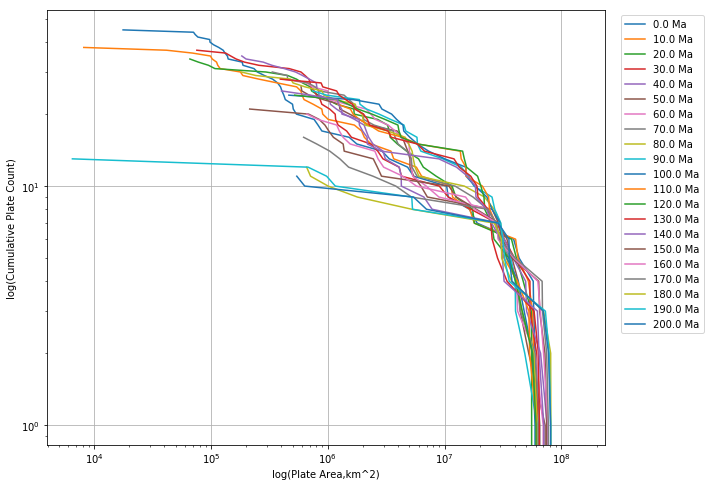

In [11]:
reconstruction_time=0.


plt.figure(figsize=(10,8))
for reconstruction_time in range(0,201,10):
    
    resolved_topologies = []
    #pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time)
    pygplates.resolve_topologies(dynamic_polygons,
                                 rotation_model,
                                 resolved_topologies,
                                 reconstruction_time,
                                 resolved_topological_sections)
    plate_areas = []

    for topology in resolved_topologies:
        # Get the plate_id and name
        plate_feature = topology.get_resolved_feature()
        # Get the plate area - note we use the built in pygplates Earth radius to get 
        plate_geometry = topology.get_resolved_geometry()
        plate_areas.append(plate_geometry.get_area()*pygplates.Earth.mean_radius_in_kms**2)

    plate_areas = np.array(plate_areas)

    plt.loglog(np.sort(plate_areas)[::-1],list(range(len(plate_areas))),label='%0.1f Ma' % reconstruction_time)

plt.xlabel('log(Plate Area,km^2)')
plt.ylabel('log(Cumulative Plate Count)')
plt.grid()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1)
plt.show()

## Extraction of Plate boundaries lenghts

The following tool allow to extract the length of (in km):
+ subduction associated with of the overriding plate
+ subduction of the subducting plate
+ subduction zones
+ midocean ridges
+ transform faults.

In [35]:
# Choose the time-step you want to study

reconstruction_time = 0.

# and the type of data you want to extract
resolved_topologies = []
resolved_topological_sections = []
pygplates.resolve_topologies(dynamic_polygons,
                             rotation_model,
                             resolved_topologies,
                             reconstruction_time,
                             resolved_topological_sections)



In [36]:
# Returns True if the specified resolved topology is the overriding plate at one of its subduction segment (also specified).
def is_overriding_plate(resolved_topology, resolved_topology_sub_segment):
    
    # Get the subduction polarity of the nearest subducting line.
    subduction_polarity = resolved_topology_sub_segment.get_feature().get_enumeration(pygplates.PropertyName.gpml_subduction_polarity)
    if (not subduction_polarity) or (subduction_polarity == 'Unknown'):
        # We don't know if it's the overriding plate, so just return false.
        return False
    
    sub_segment_reversal_flag = resolved_topology_sub_segment.was_geometry_reversed_in_topology()
    
    if resolved_topology.get_resolved_boundary().get_orientation() == pygplates.PolygonOnSphere.Orientation.clockwise:
        # The resolved boundary has clockwise orientation (when viewed from above the Earth).
        # If the overriding plate is to the 'left' of the subducting line (when following its vertices in order) and
        # the subducting line is reversed when contributing to the resolved boundary then the resolved boundary is the overriding plate.
        # A similar test applies to the 'right' but with the subducting line not reversed in the resolved boundary.
        if ((subduction_polarity == 'Left' and sub_segment_reversal_flag) or
            (subduction_polarity == 'Right' and not sub_segment_reversal_flag)):
            return True
        else:
            return False
    else:
        # The resolved boundary has counter-clockwise orientation (when viewed from above the Earth).
        # If the overriding plate is to the 'left' of the subducting line (when following its vertices in order) and
        # the subducting line is not reversed when contributing to the resolved boundary then the resolved boundary is the overriding plate.
        # A similar test applies to the 'right' but with the subducting line reversed in the topology.
        if ((subduction_polarity == 'Left' and not sub_segment_reversal_flag) or
            (subduction_polarity == 'Right' and sub_segment_reversal_flag)):
            return True
        else:
            return False



In [37]:
# Iterate over topological polygons

print("ID", ", ","subduction_length_kms", "subduction_overriding_length_kms", "subduction_subducting_length_kms", "ridge_length_kms", "transform_length_kms")
for resolved_topology in resolved_topologies:
    
    plate_id = resolved_topology.get_feature().get_reconstruction_plate_id()
    subduction_length_kms = 0
    subduction_overriding_length_kms = 0
    subduction_subducting_length_kms = 0
    ridge_length_kms = 0
    transform_length_kms = 0
    
    for sub_segment in resolved_topology.get_boundary_sub_segments():
        
        # Deal with subduction zones.....
        if sub_segment.get_resolved_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
            
            # See if resolved topology is the overriding plate at at the current subduction sub-segment.
            if is_overriding_plate(resolved_topology, sub_segment):
                subduction_overriding_length_kms += sub_segment.get_geometry().get_arc_length() * pygplates.Earth.mean_radius_in_kms
            else:
                subduction_subducting_length_kms += sub_segment.get_geometry().get_arc_length() * pygplates.Earth.mean_radius_in_kms
            
            subduction_length_kms += sub_segment.get_geometry().get_arc_length() * pygplates.Earth.mean_radius_in_kms

            
        # Deal with mid ocean ridge features (ridges + transforms)....
        elif sub_segment.get_resolved_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
            
            spreading_feature = sub_segment.get_feature()
            
            spreading_stage_rotation = separate_ridge_transform_segments.get_stage_rotation_for_reconstructed_geometry(
                                spreading_feature, rotation_model, reconstruction_time)
            if not spreading_stage_rotation:
                # Skip current feature - it's not a spreading feature.
                continue
                            
            ridge_and_transform_segment_geometries = separate_ridge_transform_segments.separate_geometry_into_ridges_and_transforms(
                                spreading_stage_rotation,
                                sub_segment.get_resolved_geometry(),
                                transform_segment_deviation_in_radians)
            if not ridge_and_transform_segment_geometries:
                # Skip shared sub segment - it's not a polyline (or polygon).
                continue

            ridge_sub_segment_geometries, transform_sub_segment_geometries = ridge_and_transform_segment_geometries
            
            for ridge_sub_segment_geometry in ridge_sub_segment_geometries:
                for segment in ridge_sub_segment_geometry.get_segments():
                    ridge_length_kms += segment.get_arc_length() * pygplates.Earth.mean_radius_in_kms
                        
            for transform_sub_segment_geometry in transform_sub_segment_geometries:
                for segment in transform_sub_segment_geometry.get_segments():
                    transform_length_kms += segment.get_arc_length() * pygplates.Earth.mean_radius_in_kms

    #break
    print(plate_id, subduction_length_kms, subduction_overriding_length_kms, subduction_subducting_length_kms, \
            ridge_length_kms, transform_length_kms)
    

ID ,  subduction_length_kms subduction_overriding_length_kms subduction_subducting_length_kms ridge_length_kms transform_length_kms
701 3796.84160567 962.982230392 2833.85937528 14153.0787423 9104.37343674
802 699.379676521 1.05505753536 698.324618986 19535.3733963 14053.6178188
503 3407.79262869 0 3407.79262869 3294.3361622 559.093371045
511 2489.52407456 0 2489.52407456 3594.95249549 1929.86036893
224 4691.06153441 3594.28278206 1096.77875235 102.845259925 0
909 2385.59872975 0 2385.59872975 3925.84230245 1368.97582513
301 15609.6664075 12340.6300707 3269.03633687 5451.37224608 1396.01091906
501 118.069762644 0 118.069762644 1725.83020789 946.9261291
659 1809.75513565 1198.42882451 611.326311144 0 126.813050682
699 1890.06845706 1890.06845706 0 872.421375835 783.372185023
911 6821.97636432 0 6821.97636432 7028.28095423 5620.885488
824 1301.65282831 1301.65282831 0 0 0
669 1051.92242933 1051.92242933 0 0 0
201 9748.66029086 7825.54060457 1923.11968629 9597.22377383 8243.75242258
709 0

## Extraction of plate velocities

In [28]:
import healpy as hp

def healpix_mesh(nSide):

    othetas,ophis = hp.pix2ang(nSide,np.arange(12*nSide**2))
    othetas = np.pi/2-othetas
    ophis[ophis>np.pi] -= np.pi*2

    # ophis -> longitude, othetas -> latitude
    return np.degrees(ophis), np.degrees(othetas)



def create_gpml_velocity_feature(longitude_array,latitude_array,filename=None,feature_type=None):
# function to make a velocity mesh nodes at an arbitrary set of points defined in Lat
# Long and Lat are assumed to be 1d arrays. 

    multi_point = pygplates.MultiPointOnSphere(list(zip(latitude_array,longitude_array)))

    # Create a feature containing the multipoint feature. 
    # optionally, define as 'MeshNode' type, so that GPlates will recognise it as a velocity layer
    if feature_type=='MeshNode':
        meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
        meshnode_feature.set_name('Velocity Mesh Nodes')
    else:
        meshnode_feature = pygplates.Feature()
        meshnode_feature.set_name('Multipoint Feature')
    
    meshnode_feature.set_geometry(multi_point)
    
    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    if filename is not None:
        output_feature_collection.write(filename)
    else:
        return output_feature_collection


def create_gpml_healpix_mesh(nSide,filename=None,feature_type=None):

    # call the function to create a healpix array
    longitude_array,latitude_array = healpix_mesh(nSide)

    # call the function to create a multipoint feature, with user-defined type
    output_feature_collection = create_gpml_velocity_feature(longitude_array,latitude_array,filename,feature_type)

    if filename is not None:  # This is superfluous, since file has already been written in previous line???
        output_feature_collection.write(filename)
    else:
        return output_feature_collection

In [29]:
#######################################################
# Define Input files for Muller 2016 AREPS model
#######################################################
# Specify the name of the GPlates rotation file



M2016 = ReconstructionModel('Matthews++2016')
M2016.add_rotation_model('Data/Matthews_etal_GPC_2016_410-0Ma_GK07.rot')
M2016.add_static_polygons('Data/Muller_etal_AREPS_2016_StaticPolygons.gpmlz')
M2016.add_dynamic_polygons('Data/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz')
M2016.add_dynamic_polygons('Data/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz')
M2016.add_dynamic_polygons('Data/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz')
M2016.add_continent_polygons('Data/Matthews_etal_GPC_2016_ContinentalPolygons.shp')


reconstruction_time, plate ID, area, area_of_continent_in_plate, Velocity


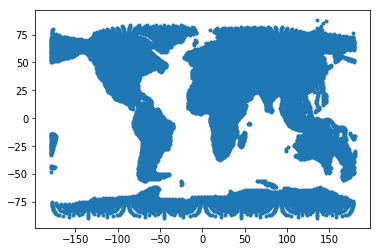

[[0.00000000e+00 7.01000000e+02 5.94022320e+07 2.93989407e+07
  1.82878945e+01]
 [0.00000000e+00 8.02000000e+02 5.78295687e+07 1.84612479e+07
  1.11715550e+01]
 [0.00000000e+00 5.03000000e+02 5.42037055e+06 4.77356608e+06
  4.09271102e+01]
 [0.00000000e+00 5.11000000e+02 1.07360272e+07 1.03773176e+04
  6.76107831e+01]
 [0.00000000e+00 2.24000000e+02 3.36003157e+06 1.81603057e+06
  1.06296847e+01]
 [0.00000000e+00 9.09000000e+02 2.91034152e+06 1.03773176e+04
  6.20301907e+01]
 [0.00000000e+00 3.01000000e+02 6.32004176e+07 5.66912859e+07
  1.02802133e+01]
 [0.00000000e+00 5.01000000e+02 1.04114151e+07 4.28583215e+06
  5.62556424e+01]
 [0.00000000e+00 6.59000000e+02 4.98855278e+05 3.42451480e+05
  1.89357226e+01]
 [0.00000000e+00 6.99000000e+02 3.71698135e+05 1.24527811e+05
  2.92199940e+01]
 [0.00000000e+00 9.11000000e+02 1.62967624e+07 3.11319527e+04
  6.79481072e+01]
 [0.00000000e+00 8.24000000e+02 8.89753593e+05 1.86791716e+05
  8.37867330e+01]
 [0.00000000e+00 6.69000000e+02 4.050610

In [30]:
def velocity_versus_crustal_type(reconstruction_model, reconstruction_time):
    snapshot = reconstruction_model.plate_snapshot(reconstruction_time)
    velocity_field = snapshot.velocity_field()

    continent_partitioner = pygplates.PlatePartitioner(reconstruction_model.continent_polygons, 
                                                       reconstruction_model.rotation_model, reconstruction_time)

    multipoint_features = create_gpml_healpix_mesh(64)
    print("reconstruction_time, plate ID, area, area_of_continent_in_plate, Velocity")
    for f in multipoint_features:
        points = f.get_geometry().get_points()
        num_points = len(f.get_geometry().get_points().to_lat_lon_list())

    normalised_area_of_one_point = ((4.*np.pi) * pygplates.Earth.mean_radius_in_kms**2)/num_points

    points_in_continents = []
    for point in points:
        if continent_partitioner.partition_point(point):
            points_in_continents.append(point)

    points_in_continent_multipoint = pygplates.Feature()
    points_in_continent_multipoint.set_geometry(pygplates.MultiPointOnSphere(points_in_continents))

    plate_partitioner = pygplates.PlatePartitioner(reconstruction_model.dynamic_polygons, 
                                                   reconstruction_model.rotation_model, reconstruction_time)
    #list of continents multipoints per plate ID
    partitioned_continent_points = plate_partitioner.partition_features(points_in_continent_multipoint)


    plt.plot(points_in_continent_multipoint.get_geometry().to_lat_lon_array()[:,1],
             points_in_continent_multipoint.get_geometry().to_lat_lon_array()[:,0],'.')
    plt.show()

    res = []
    for plate,area in zip(snapshot.plate_ids,snapshot.plate_areas):
        
        area_of_continent_in_plate = 0 
        
        for p in partitioned_continent_points:
            if p.get_reconstruction_plate_id()==plate:
                area_of_continent_in_plate += normalised_area_of_one_point * len(p.get_geometry().get_points().to_lat_lon_list())
        rms = velocity_field.rms_velocity(plate) 

        if area>0:
            res.append([reconstruction_time,plate,area,area_of_continent_in_plate,rms])
        
        else:
            print('Zero area for plate %d at time %0.1fMa' % (plate,area))
    
    print(np.array(res)) # list
    #print res # list
    #print np.array(res).T
    return res
    
# CHANGE THE TIME FOR THE ONE YOU WANT TO STUDY

res = velocity_versus_crustal_type(M2016, 0) # change for  res = velocity_versus_crustal_type(M2016, 200)


## Continental plates vs, continental area


![Plates vs continantal velocities, Zahirovic et al.](Uyeda_study/zahirovic2016.png)

Here is the associated publication [Uyeda_study/Zahirovic_2015_Tectonic_speed_limits_plate_reconstructions.pdf]




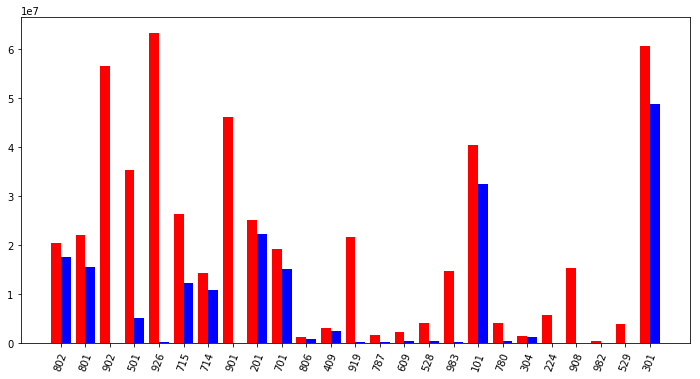

In [43]:
def velocity_versus_crustal_type(reconstruction_model, reconstruction_time):
    snapshot = reconstruction_model.plate_snapshot(reconstruction_time)
    velocity_field = snapshot.velocity_field()

    continent_partitioner = pygplates.PlatePartitioner(reconstruction_model.continent_polygons, 
                                                       reconstruction_model.rotation_model, reconstruction_time)

    multipoint_features = create_gpml_healpix_mesh(64)

    for f in multipoint_features:
        points = f.get_geometry().get_points()
        num_points = len(f.get_geometry().get_points().to_lat_lon_list())

    normalised_area_of_one_point = ((4.*np.pi) * pygplates.Earth.mean_radius_in_kms**2)/num_points

    points_in_continents = []
    for point in points:
        if continent_partitioner.partition_point(point):
            points_in_continents.append(point)

    points_in_continent_multipoint = pygplates.Feature()
    points_in_continent_multipoint.set_geometry(pygplates.MultiPointOnSphere(points_in_continents))

    plate_partitioner = pygplates.PlatePartitioner(reconstruction_model.dynamic_polygons, 
                                                   reconstruction_model.rotation_model, reconstruction_time)
    partitioned_continent_points = plate_partitioner.partition_features(points_in_continent_multipoint)


    #plt.plot(points_in_continent_multipoint.get_geometry().to_lat_lon_array()[:,1],
    #        points_in_continent_multipoint.get_geometry().to_lat_lon_array()[:,0],'.')
    #plt.show()

    res = []
    for plate,area in zip(snapshot.plate_ids,snapshot.plate_areas):

        area_of_continent_in_plate = 0
        for p in partitioned_continent_points:
            if p.get_reconstruction_plate_id()==plate:
                area_of_continent_in_plate += normalised_area_of_one_point * len(p.get_geometry().get_points().to_lat_lon_list())
        rms = velocity_field.rms_velocity(plate) 

        if area>0:
            res.append([reconstruction_time,plate,area,area_of_continent_in_plate,rms])
        else:
            print('Zero area for plate %d at time %0.1fMa' % (plate,area))

    return res
    


res = velocity_versus_crustal_type(M2016, 120)

width=0.4
    
fig, ax = plt.subplots(figsize=(12,6))
plt.bar(np.arange(len(res)),list(zip(*res))[2],width=width,color='r')
plt.bar(np.arange(len(res))+width,list(zip(*res))[3],width=width,color='b')
ax.set_xticks(np.arange(len(res))+width/2)
ax.set_xticklabels((list(zip(*res))[1]),rotation=70)
plt.show()

In [44]:
#resc = []
# Data frame template defining the column names
DataFrameTemplate = ('time','plate_id','plate_area','continental_area','rms_velocity')

# Create an empty dataframe to concatenate results to
df_M2016 = pd.DataFrame(columns=DataFrameTemplate)

for t in np.arange(0,101,10):
    #print t
    res = velocity_versus_crustal_type(M2016, t)
        
    df = pd.DataFrame(res,columns=DataFrameTemplate)
    
    #plt.plot(100*df['continental_area']/df['plate_area'],df['rms_velocity'],'o')
    
    df_M2016 = df_M2016.append(df)

    
# # Create an empty dataframe to concatenate results to
# df_Y2018 = pd.DataFrame(columns=DataFrameTemplate)

# for t in np.arange(0,401,1):
#     #print t
#     res = velocity_versus_crustal_type(Y2018, t)
        
#     df = pd.DataFrame(res,columns=DataFrameTemplate)
    
#     df_Y2018 = df_Y2018.append(df)

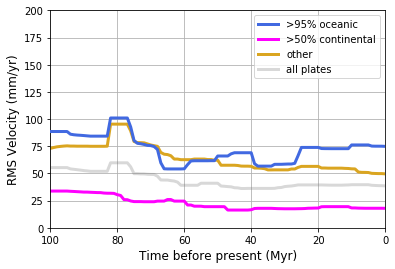

In [45]:


import scipy.signal as sig

def velocity_versus_time(df_AllTimes):
    mean_oc = []
    mean_co = []
    mean_mixed = []
    mean_global = []

    for i,time in enumerate(np.arange(0,101,1)):
        subset = df_AllTimes[df_AllTimes['time']==time].dropna()

        subset_oc = subset[(subset['continental_area']/subset['plate_area'])<0.05]    
        mean_oc.append(np.average(subset_oc['rms_velocity'],weights=subset_oc['plate_area']))

        subset_co = subset[(subset['continental_area']/subset['plate_area'])>0.5]    
        mean_co.append(np.average(subset_co['rms_velocity'],weights=subset_co['plate_area']))

        subset_mixed = subset[((subset['continental_area']/subset['plate_area'])<0.5) & 
                              ((subset['continental_area']/subset['plate_area']))>0.05]    
        mean_mixed.append(np.average(subset_mixed['rms_velocity'],weights=subset_mixed['plate_area']))

        mean_global.append(np.average(subset['rms_velocity'],weights=subset['plate_area']))


    plt.figure(figsize=(6,4))
    plt.plot(np.arange(0,101,1),sig.medfilt(mean_oc,11),'royalblue',linewidth=3,label='>95% oceanic',zorder=3)
    plt.plot(np.arange(0,101,1),sig.medfilt(mean_co,11),'magenta',linewidth=3,label='>50% continental')
    plt.plot(np.arange(0,101,1),sig.medfilt(mean_mixed,11),'goldenrod',linewidth=3,label='other')
    plt.plot(np.arange(0,101,1),sig.medfilt(mean_global,11),'grey',linewidth=3,alpha=0.3,label='all plates')
    plt.xlim(100,0)
    plt.ylim(0,200)
    plt.grid()
    plt.legend()
    plt.xlabel('Time before present (Myr)',fontsize=12)
    plt.ylabel('RMS Velocity (mm/yr)',fontsize=12)
    #plt.show()

velocity_versus_time(df_M2016)
plt.savefig('RMS_Velocity_continents_versus_oceans_M2016.png')
#velocity_versus_time(df_Y2018)
#plt.savefig('../figures/RMS_Velocity_continents_versus_oceans_Y2018.png')